# 2.4. The Adagrad Algorithm

From section 12.7.2 on Preconditioning, we have seen the idea of adjusting learning rates per coordinate and using a diagonal matrix to scale the parameter space. Now we formalize the Adagrad algorithm - a practical implementation of that idea.

---

## The Algorithm

We use the variable $\mathbf{s}_t$ to accumulate the variance of past gradients as follows:

$$
\begin{aligned}
\mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
\mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
\mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned} \tag{12.7.5}
$$

**Important note:** All operations are performed **element-wise**:

- $\mathbf{g}_t^2$ means $[g_{t,1}^2, g_{t,2}^2, \ldots, g_{t,d}^2]$
- $\sqrt{\mathbf{s}_t + \epsilon}$ means $[\sqrt{s_{t,1} + \epsilon}, \sqrt{s_{t,2} + \epsilon}, \ldots, \sqrt{s_{t,d} + \epsilon}]$
- $\frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t$ means $\left[\frac{\eta}{\sqrt{s_{t,1} + \epsilon}} \cdot g_{t,1}, \frac{\eta}{\sqrt{s_{t,2} + \epsilon}} \cdot g_{t,2}, \ldots, \frac{\eta}{\sqrt{s_{t,d} + \epsilon}} \cdot g_{t,d}\right]$

**Parameters:**
- $\eta$ - learning rate
- $\epsilon$ - small additive constant (typically $10^{-8}$) to avoid division by zero
- **Initialization:** $\mathbf{s}_0 = \mathbf{0}$

---

## Meaning of Each Step

### Step 1: Compute gradient
$$\mathbf{g}_t = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w}))$$
The gradient at the current point indicates the direction of steepest change.

### Step 2: Accumulate squared gradients
Each coordinate "remembers" its gradient history:
- If gradient is **large** many times → $\mathbf{s}_t$ accumulates large values → effective lr becomes **small**
- If gradient is **small** → $\mathbf{s}_t$ accumulates slowly → effective lr remains relatively **large**

### Step 3: Update parameters
Update with learning rate adjusted per coordinate:
- Each coordinate has its own lr: $\frac{\eta}{\sqrt{s_{t,i} + \epsilon}}$
- Learning rate decreases as $s_{t,i}$ increases

---

## Why This Design?

### Per-coordinate adaptation
In many problems, different coordinates have different "sensitivities". Coordinates that **change strongly** (large gradients) need **small** learning rates to avoid overshooting, while coordinates that **change weakly** (small gradients) need **large** learning rates to learn faster. Adagrad adjusts automatically without manual tuning for each parameter.

### Connection to Preconditioning
As analyzed in section 12.7.2, this is an application of **automatic preconditioning** - Adagrad uses the magnitude of gradients as a proxy for the diagonal of the Hessian, helping to "flatten" the objective function without computing eigenvalues.

### Geometric Interpretation
Each Adagrad step is equivalent to gradient descent with a diagonal scaling matrix $D_t = \text{diag}(1/\sqrt{s_t})$. 

Essentially, we transform the parameter space:
- Dimensions with **large** gradients are "shrunk" → small steps
- Dimensions with **small** gradients are "stretched" → large steps

This helps adjust the scale between dimensions to match the elliptical shape of the contours.

### Important Trade-off
Learning rate decreases as $O(1/\sqrt{t})$. In terms of **advantages**, the algorithm is stable and suitable for convex problems, effective with sparse data, and requires little tuning. However, the **disadvantages** are that the learning rate decreases too quickly for non-convex problems, is not optimal for deep learning, and requires variants like RMSProp or Adam to address these issues.

---

## Computational Cost

Like momentum, we need to track an **auxiliary variable** - here $\mathbf{s}_t$ - to enable per-coordinate learning rates.

**Complexity:**
- Storage: Auxiliary vector $\mathbf{s}_t \in \mathbb{R}^d$ 
- Cost: $O(d)$ - negligible
- Comparison: Computing full Hessian requires $O(d^2)$ (discussed in section 12.7.2)

The overhead is negligible - the main cost is still computing $l(y_t, f(\mathbf{x}_t, \mathbf{w}))$ and its derivatives.

---

## When to Use?

**Convex optimization**: Very good - stable and reliable convergence.

**Sparse features** (NLP, Recommender Systems): Excellent - rare words/features are learned with larger learning rates, significantly improving performance.

**Deep learning**: Use with caution - learning rate may decrease too early, consider using RMSProp or Adam instead.


---

# 3.1. Step-by-Step Calculation Example

In this section, we demonstrate Adagrad's behavior on two different objective functions:
- **Function 1 (Axis-aligned)**: Variables are independent
- **Function 2 (Rotated)**: Variables are strongly correlated

---

## Case 1: Axis-Aligned Function

### Objective Function
$$f_1(\mathbf{x}) = 0.1x_1^2 + 2x_2^2$$

This is an **axis-aligned elliptic paraboloid** where the variables $x_1$ and $x_2$ are independent.

---

### Finding the Critical Point (Theoretical Solution)

Solve the system $\nabla f_1 = \mathbf{0}$:

$$
\begin{cases}
\frac{\partial f_1}{\partial x_1} = 0.2x_1 = 0 \\
\frac{\partial f_1}{\partial x_2} = 4x_2 = 0
\end{cases}
$$

$$\Rightarrow x_1 = 0, \quad x_2 = 0$$

**Conclusion:** Minimum at $(0, 0)$ with $f_1(0, 0) = 0$

---

### Setup for Adagrad

Parameters are set as follows:
- Starting point: $\mathbf{x}^{(0)} = (x_1^{(0)}, x_2^{(0)}) = (5, 3)$
- Learning rate: $\eta = 0.4$
- Epsilon: $\varepsilon = 10^{-8}$
- Gradient formula: $\nabla f_1 = \begin{bmatrix} 0.2x_1 \\ 4x_2 \end{bmatrix}$

---

### Step-by-Step Calculations for Function 1

#### Step 1 (t=1)

**Current:** $\mathbf{x}^{(0)} = (5.0, 3.0)$

**1. Compute gradient:**
$$\mathbf{g}_1 = \begin{bmatrix} 0.2 \times 5 \\ 4 \times 3 \end{bmatrix} = \begin{bmatrix} 1.0 \\ 12.0 \end{bmatrix}$$

**2. Update accumulator $\mathbf{s}$:**
$$\mathbf{s}_1 = \begin{bmatrix} 0 \\ 0 \end{bmatrix} + \begin{bmatrix} 1.0^2 \\ 12.0^2 \end{bmatrix} = \begin{bmatrix} 1.0 \\ 144.0 \end{bmatrix}$$

**3. Compute effective learning rate:**
- For $x_1$: $\frac{\eta}{\sqrt{s_1^{(1)} + \varepsilon}} = \frac{0.4}{\sqrt{1.0}} = 0.4$
- For $x_2$: $\frac{\eta}{\sqrt{s_2^{(1)} + \varepsilon}} = \frac{0.4}{\sqrt{144.0}} = \frac{0.4}{12} \approx 0.0333$

**4. Compute update:**
$$\Delta \mathbf{x}_1 = \text{eff\_lr} \odot \mathbf{g}_1 = \begin{bmatrix} 0.4 \times 1.0 \\ 0.0333 \times 12.0 \end{bmatrix} = \begin{bmatrix} 0.4 \\ 0.4 \end{bmatrix}$$

**5. Update parameters:**
$$\mathbf{x}^{(1)} = \mathbf{x}^{(0)} - \Delta \mathbf{x}_1 = \begin{bmatrix} 5.0 - 0.4 \\ 3.0 - 0.4 \end{bmatrix} = \begin{bmatrix} 4.6 \\ 2.6 \end{bmatrix}$$

**Function value:** $f_1(4.6, 2.6) = 0.1(4.6)^2 + 2(2.6)^2 = 2.116 + 13.52 = 15.636$

---

#### Step 2 (t=2)

**Current:** $\mathbf{x}^{(1)} = (4.6, 2.6)$

**1. Gradient:**
$$\mathbf{g}_2 = \begin{bmatrix} 0.2 \times 4.6 \\ 4 \times 2.6 \end{bmatrix} = \begin{bmatrix} 0.92 \\ 10.4 \end{bmatrix}$$

**2. Update $\mathbf{s}$:**
$$\mathbf{s}_2 = \begin{bmatrix} 1.0 \\ 144.0 \end{bmatrix} + \begin{bmatrix} 0.8464 \\ 108.16 \end{bmatrix} = \begin{bmatrix} 1.8464 \\ 252.16 \end{bmatrix}$$

**3. Effective learning rate:**
- For $x_1$: $\frac{0.4}{\sqrt{1.8464}} \approx 0.2944$
- For $x_2$: $\frac{0.4}{\sqrt{252.16}} \approx 0.0252$

**4. Update:**
$$\Delta \mathbf{x}_2 = \begin{bmatrix} 0.2944 \times 0.92 \\ 0.0252 \times 10.4 \end{bmatrix} \approx \begin{bmatrix} 0.2709 \\ 0.2621 \end{bmatrix}$$

$$\mathbf{x}^{(2)} = \begin{bmatrix} 4.6 - 0.2709 \\ 2.6 - 0.2621 \end{bmatrix} = \begin{bmatrix} 4.3291 \\ 2.3379 \end{bmatrix}$$

**Function value:** $f_1(4.3291, 2.3379) \approx 12.817$

---

#### Step 3 (t=3)

**Current:** $\mathbf{x}^{(2)} \approx (4.3291, 2.3379)$

**1. Gradient:**
$$\mathbf{g}_3 = \begin{bmatrix} 0.8658 \\ 9.3516 \end{bmatrix}$$

**2. Update $\mathbf{s}$:**
$$\mathbf{s}_3 = \begin{bmatrix} 1.8464 + 0.7496 \\ 252.16 + 87.4524 \end{bmatrix} = \begin{bmatrix} 2.596 \\ 339.6124 \end{bmatrix}$$

**3. Effective learning rate:**
$$\text{eff\_lr} \approx \begin{bmatrix} 0.2482 \\ 0.0217 \end{bmatrix}$$

**4. Update:**
$$\mathbf{x}^{(3)} \approx \begin{bmatrix} 4.1142 \\ 2.1350 \end{bmatrix}$$

**Function value:** $f_1(4.1142, 2.1350) \approx 10.805$

---

### Observations for Function 1 (Axis-aligned)

1. **Effective LR adapts per coordinate:**
   - $x_1$ has small gradient (0.2 coefficient) → larger effective LR maintained
   - $x_2$ has large gradient (4.0 coefficient) → smaller effective LR

2. **Convergence is balanced:**
   - Both coordinates move toward 0 smoothly
   - The per-coordinate adaptation works **perfectly** because variables are independent

3. **Updates align with coordinate axes:**
   - Gradient always points along $x_1$ or $x_2$ axis
   - Adagrad's diagonal scaling is **ideal** for this structure


---

## Case 2: Rotated Function

### Objective Function
$$f_2(\mathbf{x}) = 0.1(x_1 + x_2)^2 + 2(x_1 - x_2)^2$$

This is a **rotated elliptic paraboloid** where variables $x_1$ and $x_2$ are strongly correlated.

---

### Finding the Critical Point

Expand the function:
$$f_2(\mathbf{x}) = 0.1(x_1^2 + 2x_1x_2 + x_2^2) + 2(x_1^2 - 2x_1x_2 + x_2^2)$$
$$= 0.1x_1^2 + 0.2x_1x_2 + 0.1x_2^2 + 2x_1^2 - 4x_1x_2 + 2x_2^2$$
$$= 2.1x_1^2 - 3.8x_1x_2 + 2.1x_2^2$$

Solve $\nabla f_2 = \mathbf{0}$:

$$
\begin{cases}
\frac{\partial f_2}{\partial x_1} = 4.2x_1 - 3.8x_2 = 0 \\
\frac{\partial f_2}{\partial x_2} = -3.8x_1 + 4.2x_2 = 0
\end{cases}
$$

From the first equation: $x_1 = \frac{3.8}{4.2}x_2 \approx 0.905x_2$

Substituting into the second equation yields $x_1 = x_2 = 0$.

**Conclusion:** Minimum at $(0, 0)$ with $f_2(0, 0) = 0$

---

### Setup for Adagrad

Parameters:
- Starting point: $\mathbf{x}^{(0)} = (5, 3)$ (same as Function 1)
- Learning rate: $\eta = 0.4$
- Epsilon: $\varepsilon = 10^{-8}$
- Gradient formula: $\nabla f_2 = \begin{bmatrix} 4.2x_1 - 3.8x_2 \\ -3.8x_1 + 4.2x_2 \end{bmatrix}$

---

### Step-by-Step Calculations for Function 2

#### Step 1 (t=1)

**Current:** $\mathbf{x}^{(0)} = (5.0, 3.0)$

**1. Compute gradient:**
$$\mathbf{g}_1 = \begin{bmatrix} 4.2 \times 5 - 3.8 \times 3 \\ -3.8 \times 5 + 4.2 \times 3 \end{bmatrix} = \begin{bmatrix} 21.0 - 11.4 \\ -19.0 + 12.6 \end{bmatrix} = \begin{bmatrix} 9.6 \\ -6.4 \end{bmatrix}$$

**2. Update $\mathbf{s}$:**
$$\mathbf{s}_1 = \begin{bmatrix} 0 \\ 0 \end{bmatrix} + \begin{bmatrix} 92.16 \\ 40.96 \end{bmatrix} = \begin{bmatrix} 92.16 \\ 40.96 \end{bmatrix}$$

**3. Effective learning rate:**
- For $x_1$: $\frac{0.4}{\sqrt{92.16}} = \frac{0.4}{9.6} \approx 0.0417$
- For $x_2$: $\frac{0.4}{\sqrt{40.96}} = \frac{0.4}{6.4} = 0.0625$

**4. Update:**
$$\Delta \mathbf{x}_1 = \begin{bmatrix} 0.0417 \times 9.6 \\ 0.0625 \times (-6.4) \end{bmatrix} = \begin{bmatrix} 0.4 \\ -0.4 \end{bmatrix}$$

$$\mathbf{x}^{(1)} = \begin{bmatrix} 5.0 - 0.4 \\ 3.0 - (-0.4) \end{bmatrix} = \begin{bmatrix} 4.6 \\ 3.4 \end{bmatrix}$$

**Function value:** $f_2(4.6, 3.4) = 0.1(8.0)^2 + 2(1.2)^2 = 6.4 + 2.88 = 9.28$

---

#### Step 2 (t=2)

**Current:** $\mathbf{x}^{(1)} = (4.6, 3.4)$

**1. Gradient:**
$$\mathbf{g}_2 = \begin{bmatrix} 4.2 \times 4.6 - 3.8 \times 3.4 \\ -3.8 \times 4.6 + 4.2 \times 3.4 \end{bmatrix} = \begin{bmatrix} 6.4 \\ -3.2 \end{bmatrix}$$

**2. Update $\mathbf{s}$:**
$$\mathbf{s}_2 = \begin{bmatrix} 92.16 + 40.96 \\ 40.96 + 10.24 \end{bmatrix} = \begin{bmatrix} 133.12 \\ 51.2 \end{bmatrix}$$

**3. Effective learning rate:**
- For $x_1$: $\frac{0.4}{\sqrt{133.12}} \approx 0.0347$
- For $x_2$: $\frac{0.4}{\sqrt{51.2}} \approx 0.0559$

**4. Update:**
$$\mathbf{x}^{(2)} \approx \begin{bmatrix} 4.6 - 0.222 \\ 3.4 - (-0.179) \end{bmatrix} = \begin{bmatrix} 4.378 \\ 3.579 \end{bmatrix}$$

**Function value:** $f_2(4.378, 3.579) \approx 6.706$

---

#### Step 3 (t=3)

**Current:** $\mathbf{x}^{(2)} \approx (4.378, 3.579)$

**1. Gradient:**
$$\mathbf{g}_3 \approx \begin{bmatrix} 4.785 \\ -1.393 \end{bmatrix}$$

**2. Update $\mathbf{s}$:**
$$\mathbf{s}_3 \approx \begin{bmatrix} 156.01 \\ 53.14 \end{bmatrix}$$

**3. Update:**
$$\mathbf{x}^{(3)} \approx \begin{bmatrix} 4.225 \\ 3.655 \end{bmatrix}$$

**Function value:** $f_2(4.225, 3.655) \approx 6.567$

---

### Observations for Function 2 (Rotated)

1. **Gradients are not axis-aligned:**
   - Gradient has components in both directions due to coupling terms
   - Direction changes as we move, not simply pointing toward origin along axes

2. **Convergence is slower:**
   - After 3 steps: Function 1 reduced to ~10.8, Function 2 to ~6.6
   - But Function 1 started at ~17.5, Function 2 at ~9.3
   - Relative progress is similar, but the path is less efficient for Function 2

3. **Per-coordinate adaptation is suboptimal:**
   - Adagrad scales $x_1$ and $x_2$ independently
   - But optimal direction is **diagonal** (along principal axes at 45°)
   - Adagrad cannot capture this cross-coordinate relationship

4. **Movement pattern:**
   - Function 1: Smooth convergence along both axes
   - Function 2: Zigzag pattern as it tries to navigate the rotated landscape

---

### Why is Function 2 More Difficult for Adagrad?

#### The Root Cause: Coordinate System Mismatch

The fundamental challenge with Function 2 stems from a **mismatch between the coordinate system we're using** ($x_1, x_2$) **and the natural geometry of the function**.

**Function 2 expanded:**
$$f_2(\mathbf{x}) = 2.1x_1^2 - 3.8x_1x_2 + 2.1x_2^2$$

The key issue is the **cross term** $-3.8x_1x_2$. This term creates **coupling** between $x_1$ and $x_2$ - you cannot optimize one coordinate independently of the other.

---

#### Understanding Through the Hessian Matrix

The Hessian matrix (second derivatives) reveals the true geometry:

**Function 1 (Axis-aligned):**
$$H_1 = \begin{bmatrix} 0.2 & 0 \\ 0 & 4 \end{bmatrix}$$

- **Diagonal matrix** → coordinates are independent
- Principal axes align with $x_1$ and $x_2$ axes
- Eigenvalues: $\lambda_1 = 0.2$, $\lambda_2 = 4$

**Function 2 (Rotated):**
$$H_2 = \begin{bmatrix} 4.2 & -3.8 \\ -3.8 & 4.2 \end{bmatrix}$$

- **Non-diagonal matrix** → coordinates are coupled through off-diagonal terms
- Principal axes are rotated 45° from coordinate axes
- **Same eigenvalues**: $\lambda_1 = 0.4$, $\lambda_2 = 8$ (just like Function 1 after accounting for the 0.1 vs 2 ratio pattern)

The eigenvalues are identical, but the **eigenvectors** (principal directions) are different:
- Function 1: Eigenvectors are $[1, 0]$ and $[0, 1]$ (along axes)
- Function 2: Eigenvectors are $[1, 1]/\sqrt{2}$ and $[1, -1]/\sqrt{2}$ (diagonal directions at ±45°)

---

#### What Adagrad Actually Does

Adagrad adjusts the learning rate **independently for each coordinate**:

$$\text{Effective LR for } x_1: \frac{\eta}{\sqrt{s_1}} \quad \text{vs} \quad \text{Effective LR for } x_2: \frac{\eta}{\sqrt{s_2}}$$

This is equivalent to applying a **diagonal scaling matrix**:
$$D_t = \text{diag}\left(\frac{1}{\sqrt{s_{t,1}}}, \frac{1}{\sqrt{s_{t,2}}}\right)$$

**Why this works for Function 1:**
- Function 1's Hessian is already diagonal → diagonally scaling the space perfectly matches the function's geometry
- Moving along $x_1$ doesn't affect the optimal step in $x_2$, and vice versa

**Why this fails for Function 2:**
- Function 2's Hessian is non-diagonal → diagonal scaling cannot capture the off-diagonal coupling
- The optimal direction is $45°$ diagonal, but Adagrad can only adjust $x_1$ and $x_2$ separately
- Moving in the $x_1$ direction requires simultaneous adjustment in $x_2$ to stay on the optimal path

---


#### Mathematical Insight: Why Independent Scaling Fails

Consider taking a step from point $(x_1, x_2)$:

**For Function 1:**
- Gradient: $\nabla f_1 = [0.2x_1, 4x_2]$
- Components are independent: changing $x_1$ only affects the $x_1$ part of gradient
- Adagrad's per-coordinate scaling is perfect

**For Function 2:**
- Gradient: $\nabla f_2 = [4.2x_1 - 3.8x_2, -3.8x_1 + 4.2x_2]$
- Components are coupled: both depend on both $x_1$ AND $x_2$
- When you step in $x_1$ direction, the gradient in BOTH directions changes
- Adagrad scales each coordinate independently → cannot handle this coupling

---

#### The Accumulator $\mathbf{s}$ Tells the Story

**Function 1:**
- $s_1$ accumulates from gradients $\propto x_1$ only
- $s_2$ accumulates from gradients $\propto x_2$ only
- Each accumulator reflects the "activity" of its own coordinate

**Function 2:**
- $s_1$ accumulates from gradients depending on BOTH $x_1$ and $x_2$
- $s_2$ accumulates from gradients depending on BOTH $x_1$ and $x_2$
- The accumulators mix information from both coordinates
- But Adagrad still treats them as independent → suboptimal

---

#### Practical Implication

From our calculations:
- **Step 1**: Both functions make similar progress
- **Step 2-3**: Function 1 converges smoothly; Function 2 shows slower, uneven progress
- **Root cause**: Function 2 requires coordinated movement in both dimensions, but Adagrad can only adjust each dimension separately

**What would work better for Function 2:**
1. **Momentum methods** (e.g., Adam): Build velocity in the optimal diagonal direction
2. **Newton's method**: Use the full Hessian (including off-diagonal terms) to find optimal direction
3. **Coordinate rotation**: Transform to the principal axes first, then apply Adagrad

---

#### Key Takeaway

Adagrad is a **diagonal** optimizer - it can only adapt learning rates along the coordinate axes independently. This is:
- ✅ **Perfect** when the problem's natural geometry aligns with coordinate axes (diagonal Hessian)
- ❌ **Suboptimal** when the problem has rotated/correlated structure (non-diagonal Hessian)

The 45° rotation doesn't change the difficulty of the optimization problem intrinsically (eigenvalues are the same), but it changes how well Adagrad's per-coordinate adaptation matches the problem structure.

---

## When Does the Algorithm Reach Optimum?

### Theoretical Optimum

For both functions, the theoretical minimum is at $\mathbf{x}^* = (0, 0)$ with $f(\mathbf{x}^*) = 0$.

**How do we know this is the optimum?**
- **First-order condition:** $\nabla f(\mathbf{x}^*) = \mathbf{0}$ (gradient is zero)
- **Second-order condition:** Hessian matrix is positive definite (all eigenvalues > 0)

Both functions satisfy these conditions at $(0, 0)$.

---

## Key Takeaway

**Adagrad works best when the objective function's principal axes align with the coordinate axes** (axis-aligned problems). For rotated or correlated problems, per-coordinate scaling is insufficient because it cannot adapt to cross-coordinate relationships. This limitation motivates more sophisticated optimizers like **Adam** (with momentum) or **Newton's method** (with full Hessian).

# 3.2. Code Illustration and Visualization

The code below implements the Adagrad algorithm to optimize both functions:
- **Function 1 (Axis-aligned)**: $f_1(\mathbf{x}) = 0.1x_1^2 + 2x_2^2$
- **Function 2 (Rotated)**: $f_2(\mathbf{x}) = 0.1(x_1 + x_2)^2 + 2(x_1 - x_2)^2$

---

## Main Components

The program consists of the following components:

- **`f1(x1, x2)` and `f2(x1, x2)`**: Compute function values
- **`grad_f1(x1, x2)` and `grad_f2(x1, x2)`**: Compute gradients
- **`adagrad_optimize()`**: Runs Adagrad with adaptive learning rate per coordinate
- **Visualization**: Compares trajectories and convergence for both functions

---

## Visualization Includes

1. **Trajectory plots**: Optimization paths on contour plots for both functions
2. **Loss convergence**: Function value decrease over iterations
3. **Effective learning rates**: How learning rates adapt per coordinate over time
4. **Side-by-side comparison**: Direct comparison of Adagrad's performance on axis-aligned vs rotated functions


                       FUNCTION 1: AXIS-ALIGNED                       
Starting: x = [5.0000, 3.0000], f(x) = 20.500000, ||∇f|| = 12.041595
Step   1: x = [ 4.6000,  2.6000] | f(x) =  15.636000 | ||∇f|| = 1.204159e+01
Step  10: x = [ 3.1656,  1.3019] | f(x) =   4.391809 | ||∇f|| = 5.586408e+00
Step  20: x = [ 2.3826,  0.7232] | f(x) =   1.613837 | ||∇f|| = 3.100146e+00
Step  30: x = [ 1.8565,  0.4155] | f(x) =   0.690007 | ||∇f|| = 1.796511e+00
Step  40: x = [ 1.4691,  0.2411] | f(x) =   0.332066 | ||∇f|| = 1.061492e+00
Step  50: x = [ 1.1723,  0.1403] | f(x) =   0.176786 | ||∇f|| = 6.390047e-01
Step  60: x = [ 0.9399,  0.0817] | f(x) =   0.101705 | ||∇f|| = 3.949359e-01
Step  70: x = [ 0.7558,  0.0476] | f(x) =   0.061667 | ||∇f|| = 2.535630e-01
Step  80: x = [ 0.6089,  0.0278] | f(x) =   0.038621 | ||∇f|| = 1.709327e-01
Step  90: x = [ 0.4911,  0.0162] | f(x) =   0.024646 | ||∇f|| = 1.213971e-01
Step 100: x = [ 0.3964,  0.0094] | f(x) =   0.015894 | ||∇f|| = 9.025707e-02
Step 110: x 

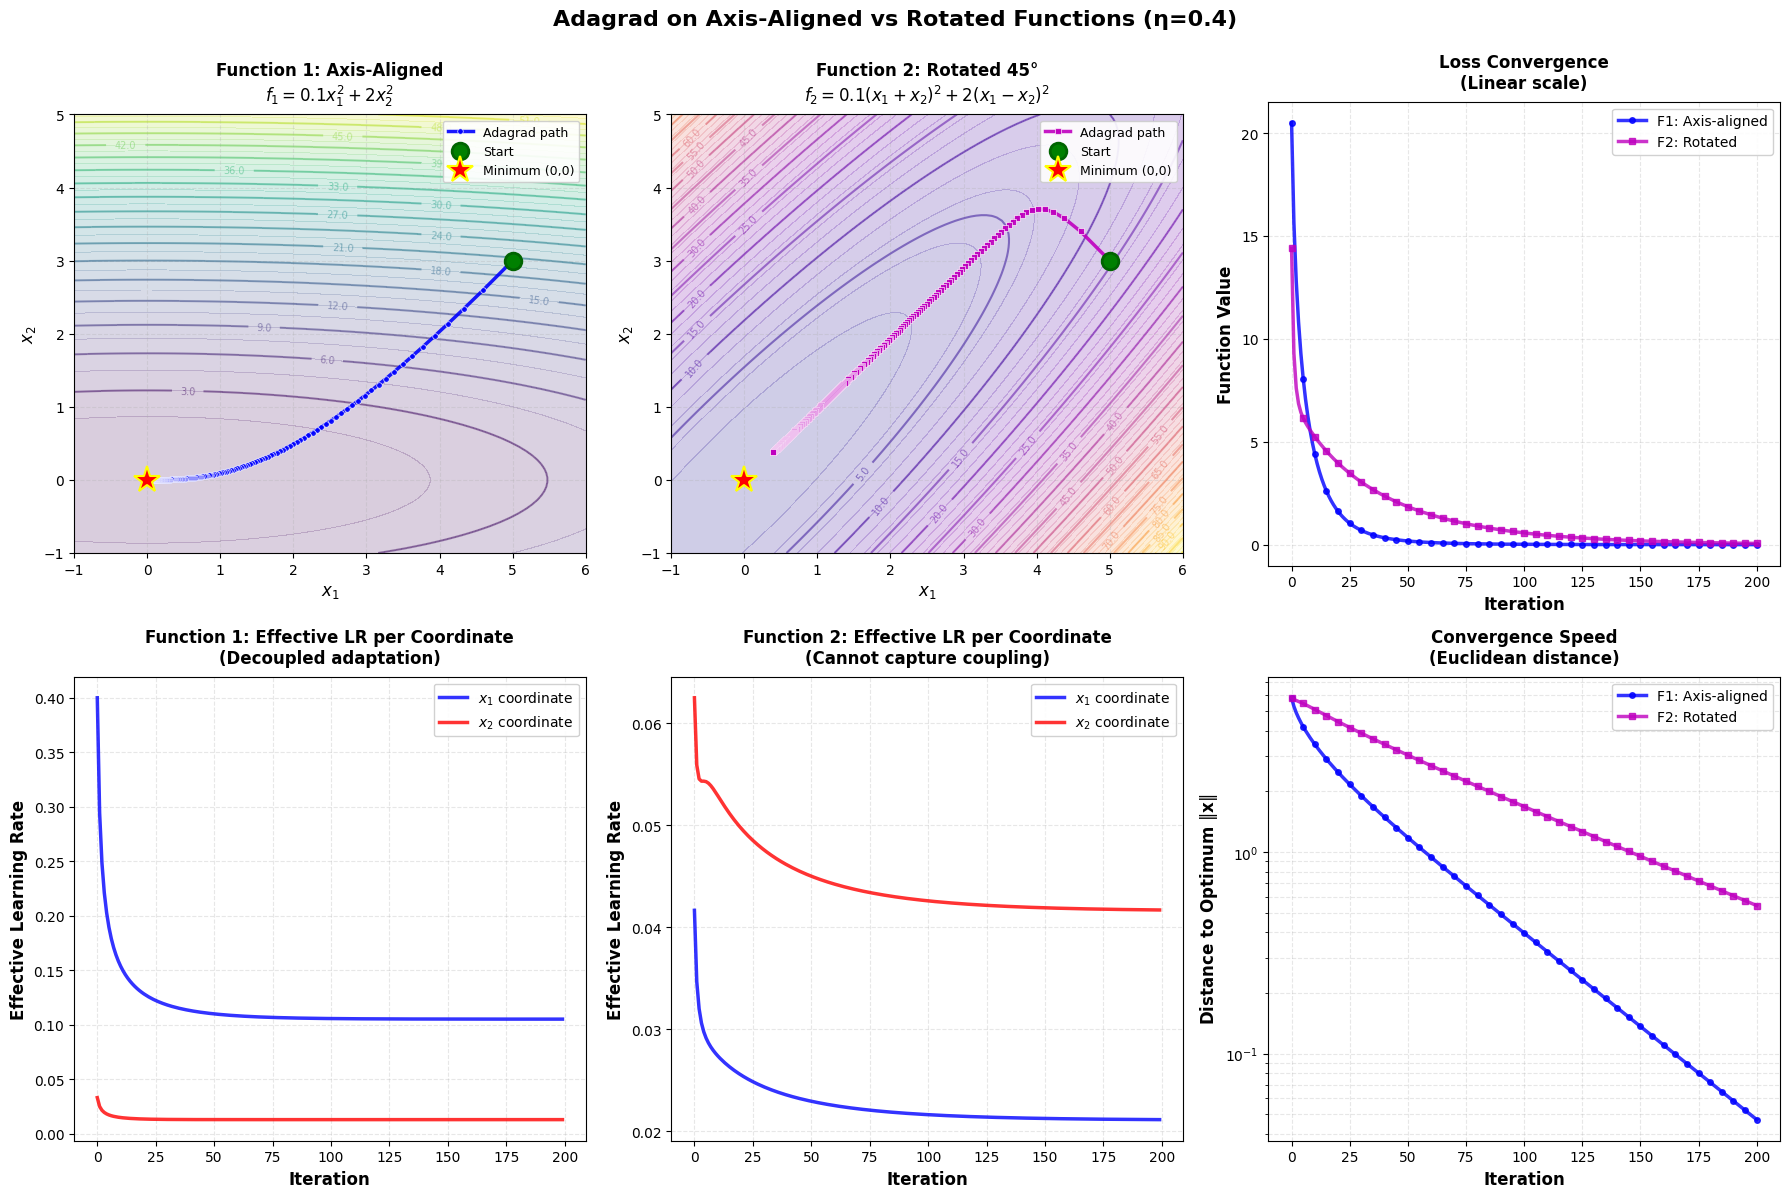


                             PERFORMANCE COMPARISON                             

       Function 1 (Axis-aligned)         |           Function 2 (Rotated)          
----------------------------------------|----------------------------------------
Steps to converge: 200                  | Steps to converge: 200
Initial loss:      20.5000           | Initial loss:      14.4000
Final loss:       0.000222           | Final loss:       0.059266
Reduction:        100.00%           | Reduction:         99.59%

--------------------------------------------------------------------------------

Final distance to optimum:
  Function 1: 0.047071              | Function 2: 0.542854

--------------------------------------------------------------------------------

Effective LR ($x_1$ coordinate):
  Initial: 0.400000                | Initial: 0.041667
  Final:   0.10529982              | Final:   0.02115220

Effective LR ($x_2$ coordinate):
  Initial: 0.033333                | Initial: 0.062500
  Fi

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# PART 1: MATHEMATICAL FUNCTION DEFINITIONS
# ============================================

def f1(x1, x2):
    """
    Function 1 (Axis-aligned): f(x) = 0.1*x1^2 + 2*x2^2
    
    Parameters:
    -----------
    x1, x2 : float or np.array
        Coordinates of the point to evaluate
    
    Returns:
    --------
    float or np.array : Function value at (x1, x2)
    """
    return 0.1 * x1**2 + 2 * x2**2

def f2(x1, x2):
    """
    Function 2 (Rotated): f(x) = 0.1*(x1 + x2)^2 + 2*(x1 - x2)^2
    
    Parameters:
    -----------
    x1, x2 : float or np.array
        Coordinates of the point to evaluate
    
    Returns:
    --------
    float or np.array : Function value at (x1, x2)
    """
    return 0.1 * (x1 + x2)**2 + 2 * (x1 - x2)**2

def grad_f1(x1, x2):
    """
    Gradient of Function 1: ∇f₁ = [0.2*x1, 4*x2]
    
    Parameters:
    -----------
    x1, x2 : float
        Coordinates of the point to compute gradient
    
    Returns:
    --------
    np.array : Gradient vector [gx1, gx2]
    """
    return np.array([0.2 * x1, 4 * x2])

def grad_f2(x1, x2):
    """
    Gradient of Function 2: ∇f₂ = [4.2*x1 - 3.8*x2, -3.8*x1 + 4.2*x2]
    
    Parameters:
    -----------
    x1, x2 : float
        Coordinates of the point to compute gradient
    
    Returns:
    --------
    np.array : Gradient vector [gx1, gx2]
    """
    return np.array([4.2*x1 - 3.8*x2, -3.8*x1 + 4.2*x2])

def adagrad_optimize(func, grad_func, x_init, eta, max_steps=1000, eps=1e-8, 
                     grad_tol=1e-4, verbose=False):
    """
    Adagrad Algorithm - Adaptive Gradient Algorithm
    
    Parameters:
    -----------
    func : function
        Objective function to minimize
    grad_func : function
        Gradient function
    x_init : np.array
        Starting point [x1, x2]
    eta : float
        Initial learning rate (η)
    max_steps : int, default=1000
        Maximum number of iterations
    eps : float, default=1e-8
        Small constant ε to avoid division by zero
    grad_tol : float, default=1e-4
        Convergence criterion: stop when ||gradient|| < grad_tol
    verbose : bool, default=False
        Print detailed information
    
    Returns:
    --------
    history_x : np.array, shape (n_steps+1, 2)
        History of coordinates through steps
    history_loss : np.array, shape (n_steps+1,)
        History of loss values
    history_eff_lr : np.array, shape (n_steps, 2)
        History of effective learning rate per coordinate
    """
    x = x_init.copy()
    s = np.zeros(2)  # Initialize accumulator s_0 = [0, 0]
    
    # Storage for history
    history_x = [x.copy()]
    history_loss = [func(x[0], x[1])]
    history_eff_lr = []
    
    # Initial gradient norm
    g = grad_func(x[0], x[1])
    grad_norm = np.linalg.norm(g)
    
    if verbose:
        print(f"Starting: x = [{x[0]:.4f}, {x[1]:.4f}], f(x) = {func(x[0], x[1]):.6f}, ||∇f|| = {grad_norm:.6f}")
    
    for t in range(1, max_steps + 1):
        # Step 1: Compute gradient
        g = grad_func(x[0], x[1])
        grad_norm = np.linalg.norm(g)
        
        # Check convergence criterion
        if grad_norm < grad_tol:
            if verbose:
                print(f"\n✓ Converged at step {t-1}: ||∇f|| = {grad_norm:.6e} < {grad_tol:.6e}")
            break
        
        # Step 2: Update accumulator s_t = s_{t-1} + g_t^2
        s = s + g**2
        
        # Step 3: Compute effective learning rate per coordinate
        eff_lr = eta / (np.sqrt(s) + eps)
        
        # Step 4: Update parameters x_t = x_{t-1} - eff_lr * g_t
        x = x - eff_lr * g
        
        # Store history
        history_x.append(x.copy())
        history_loss.append(func(x[0], x[1]))
        history_eff_lr.append(eff_lr.copy())
        
        if verbose and (t % 10 == 0 or t == 1):
            print(f"Step {t:3d}: x = [{x[0]:7.4f}, {x[1]:7.4f}] | "
                  f"f(x) = {func(x[0], x[1]):10.6f} | ||∇f|| = {grad_norm:.6e}")
    else:
        # Reached max_steps without converging
        if verbose:
            print(f"\n⚠ Reached max iterations ({max_steps}): ||∇f|| = {grad_norm:.6e} (target: {grad_tol:.6e})")
    
    if verbose:
        print(f"Final: x = [{x[0]:.6f}, {x[1]:.6f}], f(x) = {func(x[0], x[1]):.8f}\n")
    
    return np.array(history_x), np.array(history_loss), np.array(history_eff_lr)


# ============================================
# PART 2: VISUALIZATION
# ============================================

def plot_adagrad_on_two_functions(x_init, eta, max_steps=1000, grad_tol=1e-4):
    """
    Compare Adagrad performance on axis-aligned vs rotated functions
    
    Parameters:
    -----------
    x_init : np.array
        Starting point [x1, x2]
    eta : float
        Learning rate
    max_steps : int, default=1000
        Maximum number of iterations
    grad_tol : float, default=1e-4
        Convergence criterion: stop when ||gradient|| < grad_tol
    """
    # ========================================
    # Run Adagrad for both functions
    # ========================================
    print(f"\n{'='*70}")
    print(f"{'FUNCTION 1: AXIS-ALIGNED':^70}")
    print(f"{'='*70}")
    hist_x1, hist_loss1, hist_eff_lr1 = adagrad_optimize(
        f1, grad_f1, x_init, eta, max_steps, grad_tol=grad_tol, verbose=True
    )
    
    print(f"{'='*70}")
    print(f"{'FUNCTION 2: ROTATED (45°)':^70}")
    print(f"{'='*70}")
    hist_x2, hist_loss2, hist_eff_lr2 = adagrad_optimize(
        f2, grad_f2, x_init, eta, max_steps, grad_tol=grad_tol, verbose=True
    )
    
    # ========================================
    # Prepare contour plots
    # ========================================
    x1_range = np.linspace(-1, 6, 100)
    x2_range = np.linspace(-1, 5, 100)
    X1, X2 = np.meshgrid(x1_range, x2_range)
    Z1 = f1(X1, X2)
    Z2 = f2(X1, X2)
    
    # ========================================
    # Create figure with 6 subplots
    # ========================================
    fig = plt.figure(figsize=(18, 12))
    fig.suptitle(f'Adagrad on Axis-Aligned vs Rotated Functions (η={eta})', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # ----------------------------------------
    # 1. Trajectory on Function 1 (Axis-aligned)
    # ----------------------------------------
    ax1 = plt.subplot(2, 3, 1)
    contour1 = ax1.contour(X1, X2, Z1, levels=20, cmap='viridis', alpha=0.5)
    ax1.clabel(contour1, inline=True, fontsize=7, fmt='%1.1f')
    ax1.contourf(X1, X2, Z1, levels=50, cmap='viridis', alpha=0.2)
    
    # Plot trajectory
    ax1.plot(hist_x1[:, 0], hist_x1[:, 1], 'b-o', linewidth=2.5, markersize=4, 
             label='Adagrad path', alpha=0.9, markeredgecolor='white', markeredgewidth=0.5)
    
    # Mark points
    ax1.plot(x_init[0], x_init[1], 'go', markersize=12, label='Start', 
             markeredgecolor='darkgreen', markeredgewidth=2, zorder=5)
    ax1.plot(0, 0, 'r*', markersize=20, label='Minimum (0,0)', 
             markeredgecolor='yellow', markeredgewidth=1.5, zorder=5)
    
    ax1.set_xlabel('$x_1$', fontsize=12, fontweight='bold')
    ax1.set_ylabel('$x_2$', fontsize=12, fontweight='bold')
    ax1.set_title('Function 1: Axis-Aligned\n$f_1 = 0.1x_1^2 + 2x_2^2$', 
                  fontsize=12, fontweight='bold', pad=10)
    ax1.legend(fontsize=9, loc='upper right', framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_aspect('equal')
    
    # ----------------------------------------
    # 2. Trajectory on Function 2 (Rotated)
    # ----------------------------------------
    ax2 = plt.subplot(2, 3, 2)
    contour2 = ax2.contour(X1, X2, Z2, levels=20, cmap='plasma', alpha=0.5)
    ax2.clabel(contour2, inline=True, fontsize=7, fmt='%1.1f')
    ax2.contourf(X1, X2, Z2, levels=50, cmap='plasma', alpha=0.2)
    
    # Plot trajectory
    ax2.plot(hist_x2[:, 0], hist_x2[:, 1], 'm-s', linewidth=2.5, markersize=4, 
             label='Adagrad path', alpha=0.9, markeredgecolor='white', markeredgewidth=0.5)
    
    # Mark points
    ax2.plot(x_init[0], x_init[1], 'go', markersize=12, label='Start', 
             markeredgecolor='darkgreen', markeredgewidth=2, zorder=5)
    ax2.plot(0, 0, 'r*', markersize=20, label='Minimum (0,0)', 
             markeredgecolor='yellow', markeredgewidth=1.5, zorder=5)
    
    ax2.set_xlabel('$x_1$', fontsize=12, fontweight='bold')
    ax2.set_ylabel('$x_2$', fontsize=12, fontweight='bold')
    ax2.set_title('Function 2: Rotated 45°\n$f_2 = 0.1(x_1+x_2)^2 + 2(x_1-x_2)^2$', 
                  fontsize=12, fontweight='bold', pad=10)
    ax2.legend(fontsize=9, loc='upper right', framealpha=0.9)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_aspect('equal')
    
    # ----------------------------------------
    # 3. Loss convergence comparison
    # ----------------------------------------
    ax3 = plt.subplot(2, 3, 3)
    ax3.plot(hist_loss1, 'b-', linewidth=2.5, label='F1: Axis-aligned', 
             marker='o', markersize=4, markevery=5, alpha=0.8)
    ax3.plot(hist_loss2, 'm-', linewidth=2.5, label='F2: Rotated', 
             marker='s', markersize=4, markevery=5, alpha=0.8)
    
    ax3.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Function Value', fontsize=12, fontweight='bold')
    ax3.set_title('Loss Convergence\n(Linear scale)', 
                  fontsize=12, fontweight='bold', pad=10)
    ax3.legend(fontsize=10, loc='upper right', framealpha=0.9)
    ax3.grid(True, alpha=0.3, linestyle='--')
    
    # ----------------------------------------
    # 4. Effective LR for Function 1
    # ----------------------------------------
    ax4 = plt.subplot(2, 3, 4)
    ax4.plot(hist_eff_lr1[:, 0], 'b-', linewidth=2.5, label='$x_1$ coordinate', alpha=0.8)
    ax4.plot(hist_eff_lr1[:, 1], 'r-', linewidth=2.5, label='$x_2$ coordinate', alpha=0.8)
    
    ax4.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Effective Learning Rate', fontsize=12, fontweight='bold')
    ax4.set_title('Function 1: Effective LR per Coordinate\n(Decoupled adaptation)', 
                  fontsize=12, fontweight='bold', pad=10)
    ax4.legend(fontsize=10, loc='upper right', framealpha=0.9)
    ax4.grid(True, alpha=0.3, linestyle='--')
    
    # ----------------------------------------
    # 5. Effective LR for Function 2
    # ----------------------------------------
    ax5 = plt.subplot(2, 3, 5)
    ax5.plot(hist_eff_lr2[:, 0], 'b-', linewidth=2.5, label='$x_1$ coordinate', alpha=0.8)
    ax5.plot(hist_eff_lr2[:, 1], 'r-', linewidth=2.5, label='$x_2$ coordinate', alpha=0.8)
    
    ax5.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Effective Learning Rate', fontsize=12, fontweight='bold')
    ax5.set_title('Function 2: Effective LR per Coordinate\n(Cannot capture coupling)', 
                  fontsize=12, fontweight='bold', pad=10)
    ax5.legend(fontsize=10, loc='upper right', framealpha=0.9)
    ax5.grid(True, alpha=0.3, linestyle='--')
    
    # ----------------------------------------
    # 6. Distance to optimum comparison
    # ----------------------------------------
    ax6 = plt.subplot(2, 3, 6)
    dist1 = np.linalg.norm(hist_x1, axis=1)
    dist2 = np.linalg.norm(hist_x2, axis=1)
    
    ax6.plot(dist1, 'b-', linewidth=2.5, label='F1: Axis-aligned', 
             marker='o', markersize=4, markevery=5, alpha=0.8)
    ax6.plot(dist2, 'm-', linewidth=2.5, label='F2: Rotated', 
             marker='s', markersize=4, markevery=5, alpha=0.8)
    
    ax6.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Distance to Optimum $\\|\\mathbf{x}\\|$', fontsize=12, fontweight='bold')
    ax6.set_title('Convergence Speed\n(Euclidean distance)', 
                  fontsize=12, fontweight='bold', pad=10)
    ax6.set_yscale('log')
    ax6.legend(fontsize=10, loc='upper right', framealpha=0.9)
    ax6.grid(True, alpha=0.3, linestyle='--', which='both')
    
    plt.tight_layout()
    plt.show()
    
    # ========================================
    # Print comparison statistics
    # ========================================
    print(f"\n{'='*80}")
    print(f"{'PERFORMANCE COMPARISON':^80}")
    print(f"{'='*80}\n")
    
    print(f"{'Function 1 (Axis-aligned)':^40} | {'Function 2 (Rotated)':^40}")
    print(f"{'-'*40}|{'-'*40}")
    
    # Loss comparison
    loss_reduction1 = (1 - hist_loss1[-1]/hist_loss1[0]) * 100
    loss_reduction2 = (1 - hist_loss2[-1]/hist_loss2[0]) * 100
    print(f"Steps to converge: {len(hist_x1)-1:3d}                  | Steps to converge: {len(hist_x2)-1:3d}")
    print(f"Initial loss: {hist_loss1[0]:12.4f}           | Initial loss: {hist_loss2[0]:12.4f}")
    print(f"Final loss:   {hist_loss1[-1]:12.6f}           | Final loss:   {hist_loss2[-1]:12.6f}")
    print(f"Reduction:    {loss_reduction1:10.2f}%           | Reduction:    {loss_reduction2:10.2f}%")
    
    print(f"\n{'-'*80}")
    
    # Distance to optimum
    dist1_final = np.linalg.norm(hist_x1[-1])
    dist2_final = np.linalg.norm(hist_x2[-1])
    print(f"\nFinal distance to optimum:")
    print(f"  Function 1: {dist1_final:.6f}              | Function 2: {dist2_final:.6f}")
    
    print(f"\n{'-'*80}")
    
    # Effective LR comparison
    print(f"\nEffective LR ($x_1$ coordinate):")
    print(f"  Initial: {hist_eff_lr1[0,0]:.6f}                | Initial: {hist_eff_lr2[0,0]:.6f}")
    print(f"  Final:   {hist_eff_lr1[-1,0]:.8f}              | Final:   {hist_eff_lr2[-1,0]:.8f}")
    
    print(f"\nEffective LR ($x_2$ coordinate):")
    print(f"  Initial: {hist_eff_lr1[0,1]:.6f}                | Initial: {hist_eff_lr2[0,1]:.6f}")
    print(f"  Final:   {hist_eff_lr1[-1,1]:.8f}              | Final:   {hist_eff_lr2[-1,1]:.8f}")
    
    print(f"\n{'='*80}")
    
    print(f"{'='*80}\n")


# ============================================
# PART 3: EXECUTION
# ============================================

# Set parameters to match manual calculations from examples above
x_init = np.array([5.0, 3.0])  # Starting point: (5, 3)
eta = 0.4                       # Learning rate: η = 0.4
eps = 1e-8                      # Epsilon: ε = 10^-8
max_steps = 200                # Maximum iterations
grad_tol = 1e-3                 # Convergence criterion: ||∇f|| < 10^-4

# Run comparison and visualization (will stop when gradient norm < 10^-4)
plot_adagrad_on_two_functions(x_init, eta, max_steps, grad_tol)